In [2]:
# Script to clean pre-process BIOMASS INVENTORY and make spatial

# First, load packages
import pandas as pd
import os
import numpy as np
import shapely as sp
import fiona
import time

import matplotlib.pyplot as plt
import geopandas as gpd
from geopandas import GeoSeries, GeoDataFrame

import plotly.plotly as py

# only for jupyter nb to show plots inline
#%matplotlib inline 

print("*BIOMASS PREPROCESSING SCRIPT BEGINS*")

*BIOMASS PREPROCESSING SCRIPT BEGINS*


In [4]:
#check wd
#print(os.getcwd())

#change wd
os.chdir("/Users/anayahall/projects/grapevine")

#read in biomass inventory
# GROSS inventory
gbm = pd.read_csv("data/raw/biomass.inventory.csv")

# TECHNICAL inventory
tbm = pd.read_csv("data/raw/biomass.inventory.technical.csv")

In [77]:
gbm.head()
tbm.head()

gbm.columns

# check that all counties in there
len(gbm.COUNTY.unique())
#yup, plus one "other"

59

In [78]:
# EXPLORE DATA
gbm['biomass.category'].value_counts()
# same as technical

row residue                               5900
row culls                                 4425
orchard vineyard residue                  3717
orchard vineyard culls                    3186
field residue                             2655
organic fraction municipal solid waste    2378
low moisture solids                       1947
high moisture solids                      1416
forestry                                   696
manure                                     177
Name: biomass.category, dtype: int64

In [79]:
gbm['biomass.feedstock'].value_counts().head()
# same as technical
# tbm['biomass.feedstock'].value_counts().head()

POTATO               413
OTHER CRUCIFEROUS    413
VEG OTHER            413
TOMATO & EGGPLANT    413
VEG UNSP.            413
Name: biomass.feedstock, dtype: int64

In [80]:
gbm[gbm['disposal.yields'] == gbm['disposal.yields'].max()]

,COUNTY,biomass.feedstock,disposal.yields,year,biomass.category
26027,Tulare,MANURE,2528938.639,2050,manure


In [81]:
#look at just manure (if feedstock, needs to be capitalized), if category, lower case -- should be equivalent!
gbm[(gbm['biomass.feedstock'] == "MANURE") & (gbm['year'] == 2014)].head()

,COUNTY,biomass.feedstock,disposal.yields,year,biomass.category
25856,Alameda,MANURE,30611.846700,2014,manure
25857,Alpine,MANURE,596.021083,2014,manure
25858,Amador,MANURE,28287.661520,2014,manure
25859,Butte,MANURE,31633.009850,2014,manure
25860,Calaveras,MANURE,30616.484900,2014,manure


In [82]:
#start grouping by: biomass category
gbm.groupby(['biomass.category'])['disposal.yields'].sum()

biomass.category
field residue                             5.670601e+06
forestry                                  8.363639e+07
high moisture solids                      2.878861e+06
low moisture solids                       1.527702e+07
manure                                    3.440785e+07
orchard vineyard culls                    5.222257e+05
orchard vineyard residue                  1.096371e+07
organic fraction municipal solid waste    6.297142e+07
row culls                                 1.573085e+06
row residue                               1.314184e+06
Name: disposal.yields, dtype: float64

In [83]:
gbm[gbm['biomass.category'] == "manure"].groupby(['COUNTY'])['disposal.yields'].sum().head()

COUNTY
Alameda      78386.468600
Alpine        1483.436603
Amador       71370.762600
Butte        83742.977030
Calaveras    81029.550070
Name: disposal.yields, dtype: float64

In [5]:
# now load SHAPEFILE for all CA COUNTIES to merge this
print("read in CA COUNTIES shapefile")
CA = gpd.read_file("data/raw/CA_Counties/CA_Counties_TIGER2016.shp")
CA.plot()

read in CA COUNTIES shapefile


In [85]:
# type(CA)

geopandas.geodataframe.GeoDataFrame

In [6]:
# Create new geoseries of county centroids - 
# note, technically still a panda series until 'set_geomtry()' is called
CA['cocent'] = CA['geometry'].centroid
CA.tail()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,cocent
53,06,081,00277305,06081,San Mateo,San Mateo County,06,H1,G4020,488,41860,41884,A,1161658961,757412213,+37.4146633,-122.3715451,POLYGON ((-13646335.91187001 4521323.746708268...,POINT (-13620576.61254652 4500160.133383474)
54,06,093,00277311,06093,Siskiyou,Siskiyou County,06,H1,G4020,None,None,None,A,16261974847,179108278,+41.5879861,-122.5332868,POLYGON ((-13677924.00259712 5161573.733656177...,POINT (-13641131.482284 5100360.431008819)
55,06,087,00277308,06087,Santa Cruz,Santa Cruz County,06,H1,G4020,488,42100,None,A,1152967330,419570389,+37.0124883,-122.0072050,"POLYGON ((-13605100.48999848 4469147.1572919, ...",POINT (-13582080.9552777 4442146.137370988)
56,06,021,00277275,06021,Glenn,Glenn County,06,H1,G4020,None,None,None,A,3403104376,33749275,+39.6025462,-122.4016998,POLYGON ((-13680158.03494936 4814470.617666174...,POINT (-13624650.76309824 4807799.345999167)
57,06,079,00277304,06079,San Luis Obispo,San Luis Obispo County,06,H1,G4020,None,42020,None,A,8548640337,815490673,+35.3852242,-120.4475445,POLYGON ((-13490260.15243948 4272335.748360178...,POINT (-13408759.60289406 4216796.820212255)


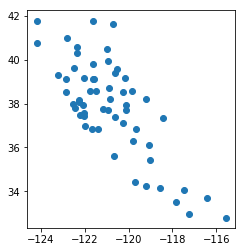

In [87]:
# both set geometry (see above) and plot to check it looks right
CA.set_geometry('cocent').plot()

In [88]:
# CREATE FIPS ID to merge with county names
#CAshape.FIPS = str(CAshape.STATEFP) + str(CAshape.COUNTYFP)
CA['FIPS']=CA['STATEFP'].astype(str)+CA['COUNTYFP']

# get rid of leading zero
CA.FIPS = [s.lstrip("0") for s in CA.FIPS]

#convert to integer for merging below
CA.FIPS = [int(i) for i in CA.FIPS]


In [89]:
# NEED TO BRING IN COUNTY NAMES TO MERGE WITH BIOMASS DATA
countyIDs = pd.read_csv("data/interim/CA_FIPS.csv", names = ["FIPS", "COUNTY", "State"])
countyIDs

type(countyIDs.FIPS[0])
type(CA.FIPS[0])

CAshape = pd.merge(CA, countyIDs, on = 'FIPS')



In [90]:
# Create subset of just county centroid points 
CAshape.head()

CA_pts = CAshape.set_geometry('cocent')[['cocent','FIPS', 'COUNTY', 'ALAND', 'AWATER']]

type(CA_pts)

# CA_pts.plot()
# CA_pts.head()

geopandas.geodataframe.GeoDataFrame

In [91]:
# type(CAshape)

In [92]:
# now can merge with biomass data finally!!!
gbm.columns
print("merging biomass data with CA shapefile")

#POLYGONS
gbm_shp = pd.merge(CAshape, gbm, on = 'COUNTY')
# Do same for technical biomass
tbm_shp = pd.merge(CAshape, tbm, on = 'COUNTY')

# COUNTY CENTROIDS

gbm_pts = pd.merge(CA_pts, gbm, on = 'COUNTY')
tbm_pts = pd.merge(CA_pts, tbm, on = 'COUNTY')

merging biomass data with CA shapefile


In [93]:
gbm_pts.head()

,cocent,FIPS,COUNTY,ALAND,AWATER,biomass.feedstock,disposal.yields,year,biomass.category
0,POINT (-118.5720592538903 34.14803912013723),6037,Los Angeles,3837562,0,APPLE,0.0,2014,orchard vineyard culls
1,POINT (-118.5720592538903 34.14803912013723),6037,Los Angeles,3837562,0,APRICOT,0.0,2014,orchard vineyard culls
2,POINT (-118.5720592538903 34.14803912013723),6037,Los Angeles,3837562,0,AVOCADO,0.0,2014,orchard vineyard culls
3,POINT (-118.5720592538903 34.14803912013723),6037,Los Angeles,3837562,0,EXOTIC,0.0,2014,orchard vineyard culls
4,POINT (-118.5720592538903 34.14803912013723),6037,Los Angeles,3837562,0,CHERRY,0.0,2014,orchard vineyard culls


In [94]:
# type(tbm_shp)
# tbm_shp.tail()

# Create subset of shapefile to see it it saves any faster
# tbm_subshp = tbm_shp[tbm_shp['biomass.category'] == 'manure']

In [95]:
# type(tbm_subshp)

In [97]:
# export as SHAPEFILE

start = time.time()


print("starting export")

gbm_out = r"/Users/anayahall/projects/grapevine/data/clean/grossbiomass_pts.shp"
tbm_out = r"/Users/anayahall/projects/grapevine/data/clean/techbiomass_pts.shp"

print("saving inventories as shapefile with county centroid pts")
gbm_pts.to_file(driver='ESRI Shapefile', filename=gbm_out)
tbm_pts.to_file(driver='ESRI Shapefile', filename=tbm_out)

end = time.time()
print(end - start)



print("BIOMASS PRE_PROCESSING DONE RUNNING")

starting export
saving inventories as shapefile with county centroid pts


/Users/anayahall/anaconda/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning:

Use fiona.Env() instead.



28.12362289428711
BIOMASS PRE_PROCESSING DONE RUNNING
